## Package Imports

In [1]:
import pyaudio
import wave
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, layers, optimizers, backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

/home/pi/Repositories/gunshot_detection/env/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/pi/Repositories/gunshot_detection/env/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/pi/Repositories/gunshot_detection/env/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/pi/Repositories/gunshot_detection/env/lib/python3.5/site-packages/librosa/ca

## Variable Initializations

In [2]:
audio_format = pyaudio.paFloat32
audio_rate = 44100
audio_channels = 1
audio_device_index = 1
audio_frames_per_buffer = 4096
audio_sample_duration = 3
input_shape = (audio_rate, 1)

## Processing Microphone Audio

In [3]:
pa = pyaudio.PyAudio()
    
stream = pa.open(format = audio_format,
                 rate = audio_rate,
                 channels = audio_channels,
                 input_device_index = audio_device_index,
                 frames_per_buffer = audio_frames_per_buffer,
                 input = True)

print("--- Recording Audio ---")
np_array_data = []

# Loops through the stream and appends audio chunks to the frame array
for i in range(0, int((audio_rate / audio_frames_per_buffer) * audio_sample_duration)):
    data = stream.read(audio_frames_per_buffer, exception_on_overflow = False)
    np_array_data.append(np.frombuffer(data, dtype=np.float32))
    
microphone_data = np.concatenate(np_array_data)
print("--- Finished Recording Audio ---")

# Stops the stream, closes it, and terminates the PyAudio instance
stream.stop_stream()
stream.close()
pa.terminate()

--- Recording Audio ---
--- Finished Recording Audio ---


## Playing Recorded Audio Sample

In [4]:
print("Maximum audio sample frequency value:", max(microphone_data))
print("The number of data points received from the microphone:", len(microphone_data))
ipd.Audio(microphone_data, rate=audio_rate)

Maximum audio sample frequency value: 0.021270752
The number of data points received from the microphone: 131072


## Resampling, Trimming, Normalizing, & Reshaping Audio Sample

In [5]:
reformed_microphone_data = librosa.resample(y=microphone_data, orig_sr=audio_rate, target_sr=22050)
reformed_microphone_data = reformed_microphone_data[:audio_rate]
reformed_microphone_data = librosa.util.normalize(reformed_microphone_data)
reformed_microphone_data = reformed_microphone_data.reshape(-1, audio_rate, 1)

## Replaying Audio Sample

In [6]:
ipd.Audio(reformed_microphone_data.reshape(44100), rate=22050)

## ROC (AUC) metric - Uses the import "from tensorflow.keras import backend as K"

In [7]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## Model Parameters

In [8]:
drop_out_rate = 0.1
learning_rate = 0.001
number_of_epochs = 100
number_of_classes = 2
batch_size = 32
optimizer = optimizers.Adam(learning_rate, learning_rate / 100)
input_tensor = Input(shape=input_shape)
metrics = [auc, "accuracy"]

Instructions for updating:
Colocations handled automatically by placer.


## Loading Original Model

In [9]:
x = layers.Conv1D(16, 9, activation="relu", padding="same")(input_tensor)
x = layers.Conv1D(16, 9, activation="relu", padding="same")(x)
x = layers.MaxPool1D(16)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPool1D(4)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPool1D(4)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(256, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(256, 3, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(rate=(drop_out_rate * 2))(x) # Increasing drop-out rate here to prevent overfitting

x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1028, activation="relu")(x)
output_tensor = layers.Dense(number_of_classes, activation="softmax")(x)

model = tf.keras.Model(input_tensor, output_tensor)
model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=metrics)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Loading Original Model Weights

In [10]:
model.load_weights("./models/gunshot_sound_model.h5")

## Classification with the Loaded Model

In [11]:
probabilities = model.predict(reformed_microphone_data)
# probabilities = model.predict(np.zeros(shape=(1, audio_rate, 1)))
print(probabilities)

[[9.9905235e-01 9.4762485e-04]]


## Viewing the Audio Sample Data

In [12]:
def show(data):
    librosa.display.waveplot(data, sr=22050)

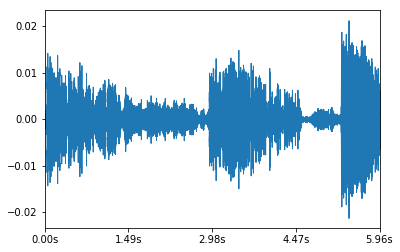

In [16]:
show(microphone_data.reshape(131072))

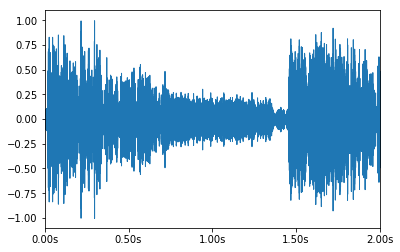

In [17]:
show(reformed_microphone_data.reshape(audio_rate))